# CS109A Final Project - Milestone 2
### Ilona Demler, Daniela Garcia, Kayla Manning, Saul Soto

This notebook contains the code used to produce our Milestone 2 Report.

## Import Libraries



In [1]:
# import standard libraries
import os
import pandas as pd
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import itertools
import math

# import model tools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# import models objects
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# import viz libraries
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

## Loading the Data



In [3]:
# get slice names (replace this with your own file path)
path_stem = "/Users/ilonademler/Documents/Harvard/Junior_fall/cs_109/final_project/cs109a-final-project/Data/data/"
file_names = os.listdir(path_stem)
print(len(file_names))
assert len(file_names) == 1000

# create empty data frame to store concatenated slices
playlist_data_raw = pd.DataFrame()

# combine each slice into one data frame 
for file in file_names:
    print(file)
    data_temp = pd.read_csv(path_stem + file)
    playlist_data_raw = playlist_data_raw.append(data_temp, ignore_index = True)    

1000
mpd.slice.292000-292999.csv
mpd.slice.991000-991999.csv
mpd.slice.536000-536999.csv
mpd.slice.444000-444999.csv
mpd.slice.11000-11999.csv
mpd.slice.461000-461999.csv
mpd.slice.513000-513999.csv
mpd.slice.138000-138999.csv
mpd.slice.895000-895999.csv
mpd.slice.396000-396999.csv
mpd.slice.540000-540999.csv
mpd.slice.432000-432999.csv
mpd.slice.798000-798999.csv
mpd.slice.417000-417999.csv
mpd.slice.565000-565999.csv
mpd.slice.56000-56999.csv
mpd.slice.22000-22999.csv
mpd.slice.727000-727999.csv
mpd.slice.655000-655999.csv
mpd.slice.329000-329999.csv
mpd.slice.958000-958999.csv
mpd.slice.670000-670999.csv
mpd.slice.702000-702999.csv
mpd.slice.751000-751999.csv
mpd.slice.623000-623999.csv
mpd.slice.187000-187999.csv
mpd.slice.879000-879999.csv
mpd.slice.65000-65999.csv
mpd.slice.208000-208999.csv
mpd.slice.606000-606999.csv
mpd.slice.774000-774999.csv
mpd.slice.589000-589999.csv
mpd.slice.471000-471999.csv
mpd.slice.503000-503999.csv
mpd.slice.128000-128999.csv
mpd.slice.981000-981999

mpd.slice.337000-337999.csv
mpd.slice.946000-946999.csv
mpd.slice.834000-834999.csv
mpd.slice.493000-493999.csv
mpd.slice.739000-739999.csv
mpd.slice.312000-312999.csv
mpd.slice.260000-260999.csv
mpd.slice.811000-811999.csv
mpd.slice.963000-963999.csv
mpd.slice.930000-930999.csv
mpd.slice.84000-84999.csv
mpd.slice.842000-842999.csv
mpd.slice.233000-233999.csv
mpd.slice.341000-341999.csv
mpd.slice.597000-597999.csv
mpd.slice.6000-6999.csv
mpd.slice.39000-39999.csv
mpd.slice.618000-618999.csv
mpd.slice.867000-867999.csv
mpd.slice.915000-915999.csv
mpd.slice.364000-364999.csv
mpd.slice.216000-216999.csv
mpd.slice.199000-199999.csv
mpd.slice.793000-793999.csv
mpd.slice.145000-145999.csv
mpd.slice.93000-93999.csv
mpd.slice.160000-160999.csv
mpd.slice.439000-439999.csv
mpd.slice.697000-697999.csv
mpd.slice.518000-518999.csv
mpd.slice.69000-69999.csv
mpd.slice.133000-133999.csv
mpd.slice.116000-116999.csv
mpd.slice.299000-299999.csv
mpd.slice.226000-226999.csv
mpd.slice.354000-354999.csv
mpd.

mpd.slice.982000-982999.csv
mpd.slice.457000-457999.csv
mpd.slice.525000-525999.csv
mpd.slice.620000-620999.csv
mpd.slice.752000-752999.csv
mpd.slice.379000-379999.csv
mpd.slice.908000-908999.csv
mpd.slice.184000-184999.csv
mpd.slice.777000-777999.csv
mpd.slice.605000-605999.csv
mpd.slice.656000-656999.csv
mpd.slice.724000-724999.csv
mpd.slice.829000-829999.csv
mpd.slice.258000-258999.csv
mpd.slice.701000-701999.csv
mpd.slice.673000-673999.csv
mpd.slice.395000-395999.csv
mpd.slice.896000-896999.csv
mpd.slice.8000-8999.csv
mpd.slice.168000-168999.csv
mpd.slice.431000-431999.csv
mpd.slice.543000-543999.csv
mpd.slice.566000-566999.csv
mpd.slice.414000-414999.csv
mpd.slice.992000-992999.csv
mpd.slice.291000-291999.csv
mpd.slice.447000-447999.csv
mpd.slice.5000-5999.csv
mpd.slice.535000-535999.csv
mpd.slice.510000-510999.csv
mpd.slice.462000-462999.csv
mpd.slice.86000-86999.csv
mpd.slice.889000-889999.csv
mpd.slice.52000-52999.csv
mpd.slice.177000-177999.csv
mpd.slice.152000-152999.csv
mpd.

mpd.slice.135000-135999.csv
mpd.slice.420000-420999.csv
mpd.slice.552000-552999.csv
mpd.slice.384000-384999.csv
mpd.slice.887000-887999.csv
mpd.slice.92000-92999.csv
mpd.slice.179000-179999.csv
mpd.slice.577000-577999.csv
mpd.slice.405000-405999.csv
mpd.slice.456000-456999.csv
mpd.slice.524000-524999.csv
mpd.slice.68000-68999.csv
mpd.slice.983000-983999.csv
mpd.slice.280000-280999.csv
mpd.slice.501000-501999.csv
mpd.slice.473000-473999.csv
mpd.slice.368000-368999.csv
mpd.slice.919000-919999.csv
mpd.slice.195000-195999.csv
mpd.slice.631000-631999.csv
mpd.slice.743000-743999.csv
mpd.slice.766000-766999.csv
mpd.slice.614000-614999.csv
mpd.slice.647000-647999.csv
mpd.slice.735000-735999.csv
mpd.slice.710000-710999.csv
mpd.slice.662000-662999.csv
mpd.slice.838000-838999.csv
mpd.slice.249000-249999.csv
mpd.slice.567000-567999.csv
mpd.slice.415000-415999.csv
mpd.slice.430000-430999.csv
mpd.slice.542000-542999.csv
mpd.slice.169000-169999.csv
mpd.slice.897000-897999.csv
mpd.slice.394000-394999.

In [4]:
# sample data 
playlist_data_sample = playlist_data_raw.sample(10000, random_state = 109, ignore_index = True)
playlist_data_sample.head()

,Unnamed: 0,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,798,good songs,False,327798,1508457600,17,16,1,"[{'pos': 0, 'artist_name': 'Rihanna', 'track_u...",5,3825874,15,NaN
1,936,edm,False,626936,1434067200,104,81,1,"[{'pos': 0, 'artist_name': 'deadmau5', 'track_...",2,25658396,59,NaN
2,331,Dance Tunes,False,661331,1450742400,110,98,2,"[{'pos': 0, 'artist_name': 'Rihanna', 'track_u...",65,26698687,81,NaN
3,820,Work,False,626820,1497225600,5,5,1,"[{'pos': 0, 'artist_name': 'Jeezy', 'track_uri...",4,1315638,4,NaN
4,575,throwbacks,False,766575,1485388800,120,94,4,"[{'pos': 0, 'artist_name': 'Rihanna', 'track_u...",5,27613869,58,NaN


In [5]:
# # save sampled dataset so that above process doesn't need to be rerun each time

# data_sample_file = "/Users/ilonademler/Documents/Harvard/Junior_fall/cs_109/final_project/cs109a-final-project/Data/data_sample.csv"
# playlist_data_sample.to_csv(data_sample_file)

In [8]:
# data_sample_file = "/Users/ilonademler/Documents/Harvard/Junior_fall/cs_109/final_project/cs109a-final-project/Data/data_sample.csv"
# data_sam = pd.read_csv(data_sample_file)
# data_sam.head()

,Unnamed: 0,Unnamed: 0.1,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,0,798,good songs,False,327798,1508457600,17,16,1,"[{'pos': 0, 'artist_name': 'Rihanna', 'track_u...",5,3825874,15,NaN
1,1,936,edm,False,626936,1434067200,104,81,1,"[{'pos': 0, 'artist_name': 'deadmau5', 'track_...",2,25658396,59,NaN
2,2,331,Dance Tunes,False,661331,1450742400,110,98,2,"[{'pos': 0, 'artist_name': 'Rihanna', 'track_u...",65,26698687,81,NaN
3,3,820,Work,False,626820,1497225600,5,5,1,"[{'pos': 0, 'artist_name': 'Jeezy', 'track_uri...",4,1315638,4,NaN
4,4,575,throwbacks,False,766575,1485388800,120,94,4,"[{'pos': 0, 'artist_name': 'Rihanna', 'track_u...",5,27613869,58,NaN


## Cleaning the Data



In [9]:
# clean data

# initialize popular names, artists, songs
popular_names = ["country", "chill", "rap", "workout", "oldies", "christmas", "rock", "party", "throwback", 
                 "jams", "worship", "summer", "feels", "new", "disney", "lit", "throwbacks", "music", "sleep", "vibes"]

popular_artists = ["Drake", "Kanye West", "Kendrick Lamar", "Rihanna", "The Weeknd", "Eminem", "Ed Sheeran", "Future", 
                   "Justin Bieber", "J. Cole", "Beyoncé", "The Chainsmokers", "Chris Brown", "Calvin Harris", 
                   "Twenty One Pilots", "Lil Uzi Vert", "Post Malone", "Big Sean", "Maroon 5", "JAY Z"]

popular_tracks = ["HUMBLE. by Kendrick Lamar", "One Dance by Drake", "Broccoli (feat. Lil Yachty) by DRAM", 
                  "Closer by The Chainsmokers", "Congratulations by Post Malone", "Caroline by Aminé", 
                  "iSpy (feat. Lil Yachty) by KYLE", "Bad and Boujee (feat. Lil Uzi Vert) by Migos", "Location by Khalid",
                  "XO TOUR Llif3 by Lil Uzi Vert", "Bounce Back by Big Sean", "Ignition - Remix by R. Kelly", 
                  "No Role Modelz by J. Cole", "Mask Off by Future", "No Problem (feat. Lil Wayne & 2 Chainz) by Chance The Rapper",
                  "I'm the One by DJ Khaled", "Jumpman by Drake", "goosebumps by Travis Scott", "Fake Love by Drake",
                  "Despacito - Remix by Luis Fonsi"]

# extract predictor variables that don't need cleaning
playlist_data = playlist_data_sample[["num_tracks", "num_albums", "num_followers", "duration_ms", "num_artists"]].copy()

# initialize binary variables
playlist_data[["collaborative"]] = np.where(playlist_data_sample[["collaborative"]] == True, 1, 0)
playlist_data[["has_description"]] = np.where(playlist_data_sample[["description"]].isna(), 0, 1)

# create popular_name variable
popular_name = []
for playlist_name in playlist_data_sample["name"]:
    popular_name.append(np.where(any([name in playlist_name.lower() for name in popular_names]), 1, 0))
playlist_data[["popular_name"]] = pd.DataFrame(popular_name)

# extract track information
total_popular_tracks = []
total_popular_artists = []
playlist_tracks = playlist_data_sample["tracks"]

# iterate through each playlist
for track_data in playlist_tracks:
    # convert string to code
    track_data = eval(track_data)
    
    # initialize empty data frames to store data for each song in playlist
    pop_tracks = []
    pop_artists = []
    
    # iterate through each song in playlist
    for track_dict in track_data:
        track_name = track_dict["track_name"]
        artist_name = track_dict["artist_name"]
        
        # check if track name is popular
        if track_name + " by " + artist_name in popular_tracks:
            pop_tracks.append(1)
        else:
            pop_tracks.append(0)
        
        # check if artist name is popular
        if artist_name in popular_artists:
            pop_artists.append(1)
        else:
            pop_artists.append(0)
        
    
    # compute sum of popular songs and artists for that playlist
    total_popular_tracks.append(sum(pop_tracks))
    total_popular_artists.append(sum(pop_artists))

# add sums as new columns in data frame  
playlist_data[["total_popular_tracks"]] = pd.DataFrame(total_popular_tracks)
playlist_data[["total_popular_artists"]] = pd.DataFrame(total_popular_artists)


In [10]:
# display cleaned data
display(playlist_data.head())
display(playlist_data.describe())

,num_tracks,num_albums,num_followers,duration_ms,num_artists,collaborative,has_description,popular_name,total_popular_tracks,total_popular_artists
0,17,16,1,3825874,15,0,0,0,0,2
1,104,81,1,25658396,59,0,0,0,0,4
2,110,98,2,26698687,81,0,0,0,0,8
3,5,5,1,1315638,4,0,0,0,0,1
4,120,94,4,27613869,58,0,0,1,0,18


,num_tracks,num_albums,num_followers,duration_ms,num_artists,collaborative,has_description,popular_name,total_popular_tracks,total_popular_artists
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,66.039400,49.224600,7.222200,1.553567e+07,37.72630,0.024500,0.016100,0.266100,0.708700,5.623600
std,53.418336,39.731522,464.454494,1.281837e+07,29.89725,0.154603,0.125866,0.441939,1.873178,11.172216
min,5.000000,2.000000,1.000000,7.407180e+05,3.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,20.000000,1.000000,5.940957e+06,16.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,37.000000,1.000000,1.144361e+07,29.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,91.000000,67.000000,1.000000,2.127437e+07,51.00000,0.000000,0.000000,1.000000,0.000000,6.000000
max,250.000000,233.000000,45942.000000,1.196490e+08,213.00000,1.000000,1.000000,1.000000,18.000000,187.000000


## Generating Train and Test Sets



In [11]:
# split data into training and test data
X_data = playlist_data[["popular_name", "has_description", "num_artists", "num_albums", "num_tracks", 
                        "duration_ms", "collaborative", "total_popular_tracks", "total_popular_artists"]].copy()
y_data = playlist_data["num_followers"].copy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size = 0.8, random_state = 109)

determine whether the response variable should be continuous or categorical:

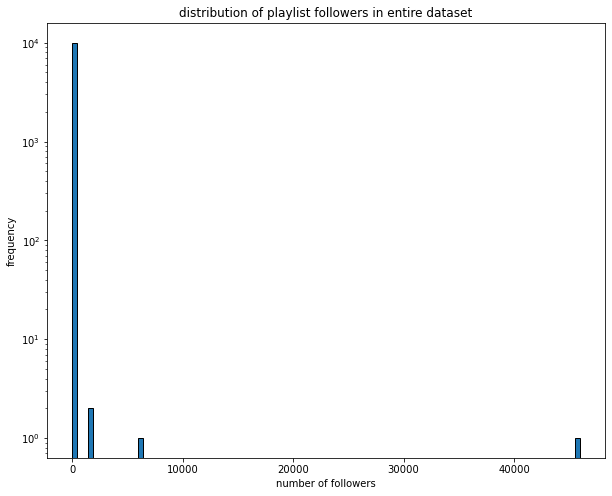

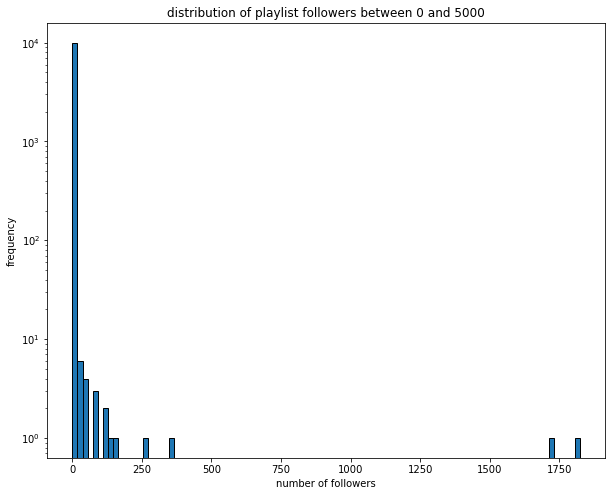

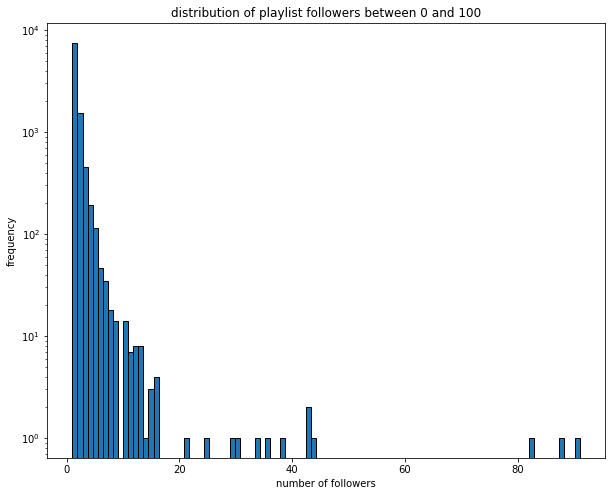

In [45]:
# plt.hist(y_train, edgecolor = 'black', bins=20)
# plt.yscale("log")
# plt.title("distribution of playlist followers in training dataset")
# plt.xlabel("number of followers")
# plt.ylabel("frequency")
# plt.show()

# plt.hist(y_test, edgecolor = 'black', bins=20)
# plt.yscale("log")
# plt.title("distribution of playlist followers in testing dataset")
# plt.xlabel("number of followers")
# plt.ylabel("frequency")
# plt.show()

plt.figure(figsize=(10,8))
plt.hist(y_data, edgecolor = 'black', bins=100)
plt.yscale("log")
plt.title("distribution of playlist followers in entire dataset")
plt.xlabel("number of followers")
plt.ylabel("frequency")
plt.show()

plt.figure(figsize=(10,8))
plt.hist(y_data[y_data<5000], edgecolor = 'black', bins=100)
plt.yscale("log")
plt.title("distribution of playlist followers between 0 and 5000")
plt.xlabel("number of followers")
plt.ylabel("frequency")
plt.show()

plt.figure(figsize=(10,8))
plt.hist(y_data[y_data<100], edgecolor = 'black', bins=100)
plt.yscale("log")
plt.title("distribution of playlist followers between 0 and 100")
plt.xlabel("number of followers")
plt.ylabel("frequency")
plt.show()

Looks like data largely falls into either under 20 followers, 20 - 5000 followers, or 40000+ followers....

## EDA

